In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
from jax import lax
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pfjax as pf
import pfjax.sde as sde

from functools import partial

from pfjax import particle_resamplers as resampler

import time
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

# needed for local imports in Jupyter:
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)

In [3]:
from pmmh import *
from sv_model import * 
from utils import * 

In [33]:
key = random.PRNGKey(123)

_dt = 1
_n_res = 5
n_obs = 1400

# parameters: 
_theta = 0.2
kappa = -0.05
sigma_z = 0.12
mu = 0.008

theta = jnp.array([_theta, kappa, mu])
x_init = jnp.block([[jnp.zeros((_n_res-1, 2))],
                    [jnp.array([2.0, 45.0])]])

volmodel = StochVol(_dt, _n_res, sigma_z=sigma_z)
y_meas1, x_state1 = pf.simulate(volmodel, key, n_obs, x_init, theta)

In [34]:
h1 = y_meas1
h2 = y_meas1[::7]

n_res1 = _n_res
n_res2 = _n_res*7

dt1 = _dt
dt2 = _dt*7

In [35]:
volmodel1 = StochVol(dt1, n_res1, sigma_z=sigma_z)
volmodel2 = StochVol(dt2, n_res2, sigma_z=sigma_z)

In [36]:
def sv_logprior (theta):
    return 0.0

n_particles = 100
n_iter = 1000
theta_init = theta

key = random.PRNGKey(456)
keys = random.split(key,3)

In [37]:
start = time.perf_counter()
h1_params = parameter_estimates(
    keys[0],
    model=volmodel1,
    y_meas=h1,
    theta_init=theta_init,
    logprior=sv_logprior,
    n_particles=n_particles,
    n_iter = n_iter,
    adapt_max = 0.1
)
print("Time: ", time.perf_counter() - start)

Acceptance rate:  [0.468 0.468 0.43 ]
Time:  590.8390666670002


In [38]:
start = time.perf_counter()
h2_params = parameter_estimates(
    keys[1],
    model=volmodel2,
    y_meas=h2,
    theta_init=theta_init,
    logprior=sv_logprior,
    n_particles=n_particles,
    n_iter = n_iter,
    adapt_max = 0.1
)
print("Time: ", time.perf_counter() - start)

Acceptance rate:  [0.451 0.439 0.461]
Time:  526.5846329999995


In [39]:
posterior1 = pd.DataFrame(
    h1_params["theta"], 
    columns = ["theta", "kappa", "mu"])
posterior1["Selection"] = "First"

posterior2 = pd.DataFrame(
    h2_params["theta"], 
    columns = ["theta", "kappa", "mu"])
posterior2["Selection"] = "Second"

double_posteriors = pd.melt(pd.concat([posterior1, posterior2]), id_vars=["selection"], var_name = "param")

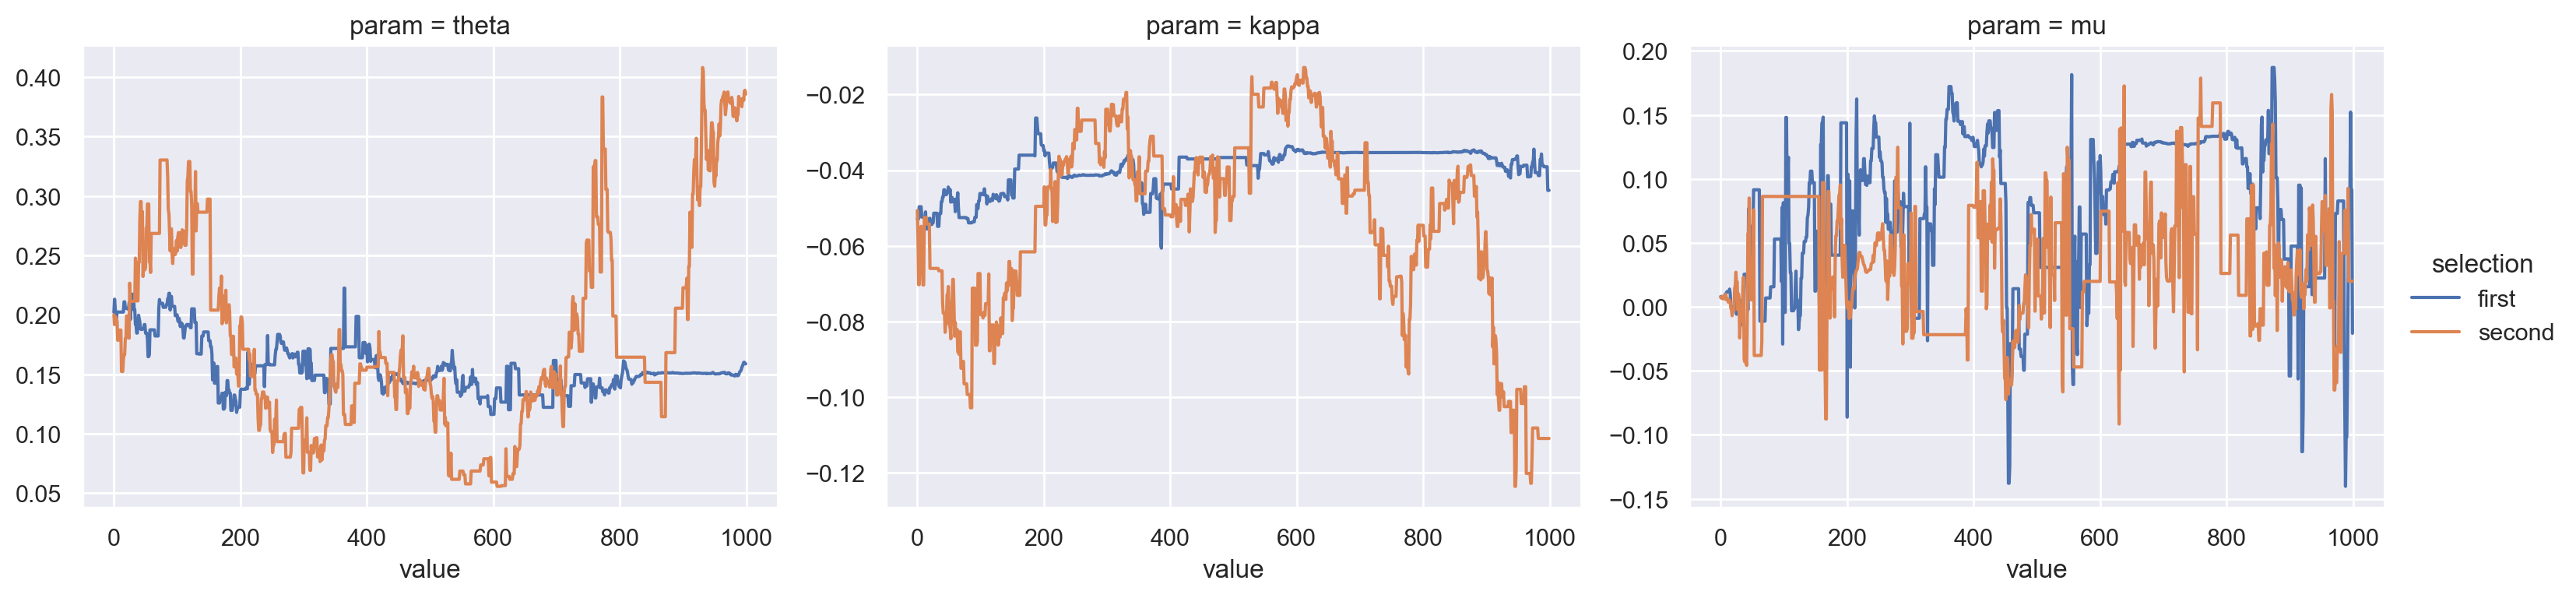

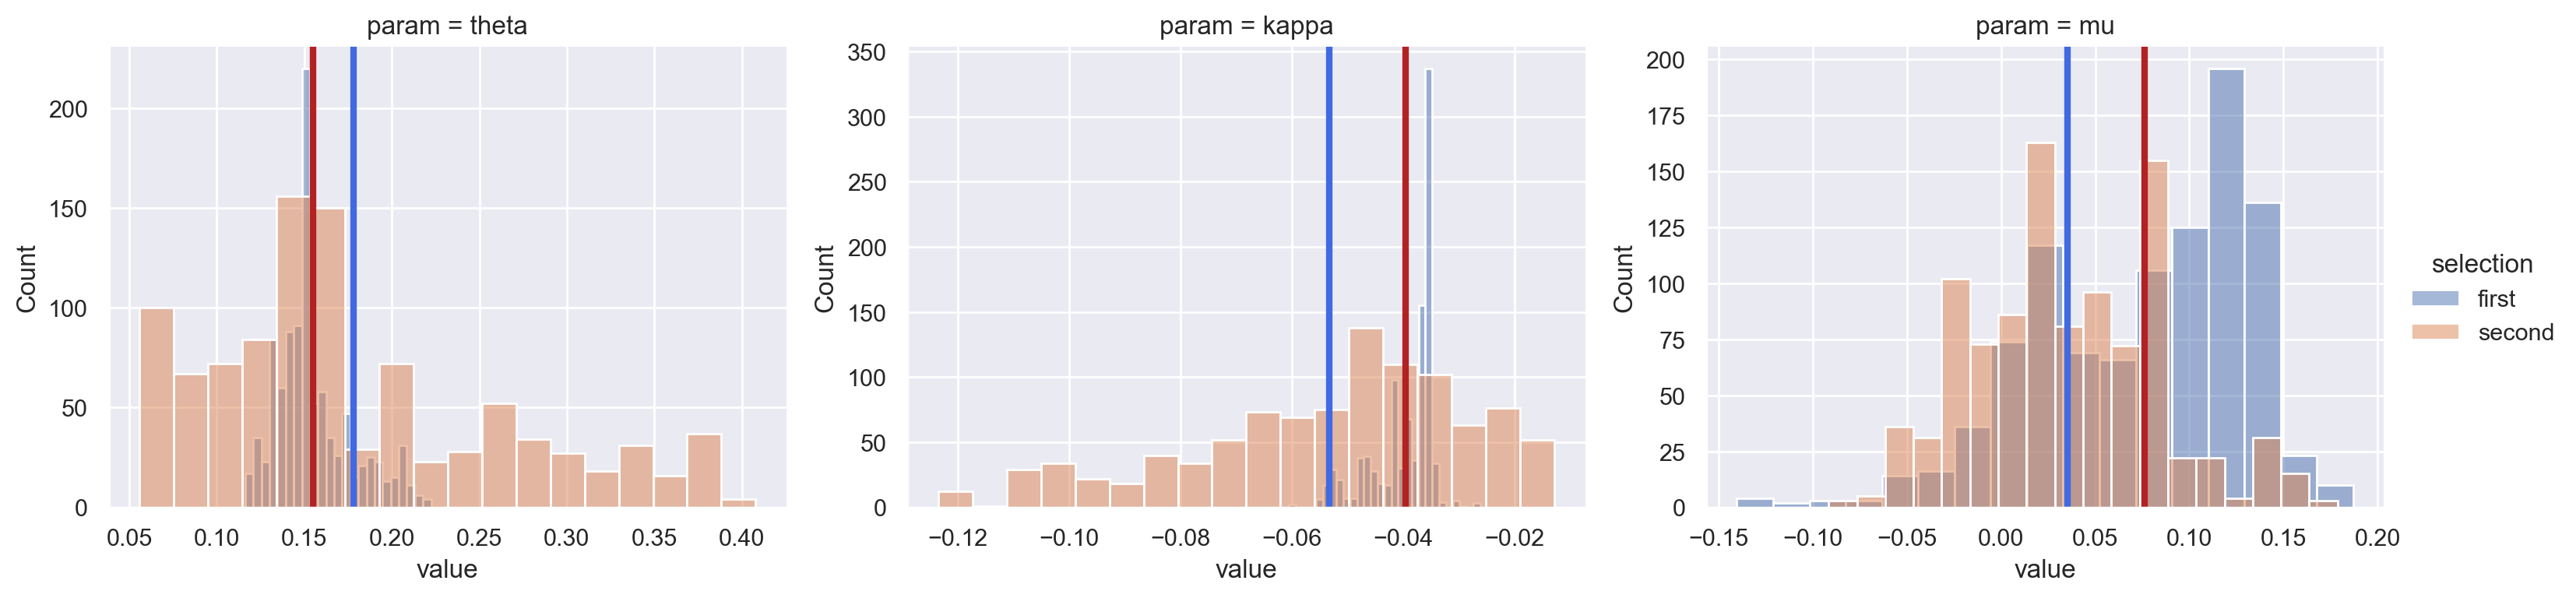

In [46]:
g = sns.FacetGrid(double_posteriors,
                  sharex=True, sharey=False,
                  col="param", hue="Selection",
                  height=4, aspect=1.3)
g.map(plt.plot, "value")
g.add_legend();

g = sns.FacetGrid(double_posteriors,
                  sharex=False, sharey=False,
                  col="param", hue="Selection",
                  height=4, aspect=1.3)
g.map(sns.histplot, "value", alpha=0.5)
[g.axes[0][i].axvline(x=h1_params["theta"][:, i].mean(), color = "firebrick", ls='-', linewidth = 3) for i in range(len(theta))];
[g.axes[0][i].axvline(x=h2_params["theta"][:, i].mean(), color = "royalblue", ls='-', linewidth = 3) for i in range(len(theta))];
g.add_legend();